In [1]:
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cpu")

In [3]:
columns = ['Date', 'Time', 'Choke', 'Psig', 'APsig', 'BOPD (Oil)', 'MMSCFD (Gas)', 'BWPD (Air)']

In [4]:
df_data = pd.read_excel('data.xlsx')
df_data = df_data[columns]

In [5]:
# fill error data
df_data = df_data.ffill()

In [6]:
datetime = pd.to_datetime(df_data['Date'].map(str) + ' ' + df_data['Time'].map(str))

/tmp/ipykernel_2812/3734410702.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime = pd.to_datetime(df_data['Date'].map(str) + ' ' + df_data['Time'].map(str))


In [7]:
df_data['Datetime'] = datetime
df_data = df_data.set_index('Datetime')

In [8]:
df_data = df_data.drop('Date', axis=1)
df_data = df_data.drop('Time', axis=1)

In [9]:
df_data

,Choke,Psig,APsig,BOPD (Oil),MMSCFD (Gas),BWPD (Air)
Datetime,,,,,,
2021-05-15 21:00:00,38,935,320,698.900,4.980,23.600
2021-05-15 21:15:00,38,935,321,822.500,4.988,32.600
2021-05-15 21:30:00,38,940,318,661.400,5.070,26.200
2021-05-15 21:45:00,38,938,317,737.700,5.061,29.200
2021-05-15 22:00:00,38,940,319,661.400,5.078,26.200
...,...,...,...,...,...,...
2021-01-06 11:00:00,42,988,327,817.992,7.534,17.856
2021-01-06 11:15:00,42,990,328,809.208,7.545,17.664
2021-01-06 11:30:00,42,986,326,810.048,7.522,17.664


In [10]:
# Oil
df_data_naive = df_data.copy(deep=True)
df_data_naive['OilPrev'] = df_data_naive['BOPD (Oil)'].shift(1)
df_data_naive.drop(df_data_naive.index[0], inplace=True)
df_data_naive['difference'] = df_data_naive['BOPD (Oil)'] - df_data_naive['OilPrev']
df_data_naive['square_error'] = df_data_naive['difference'] ** 2

print(df_data_naive.head())

square_error = df_data_naive['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

                     Choke  Psig  APsig  BOPD (Oil)  MMSCFD (Gas)  BWPD (Air)  \
Datetime                                                                        
2021-05-15 21:15:00     38   935    321       822.5         4.988        32.6   
2021-05-15 21:30:00     38   940    318       661.4         5.070        26.2   
2021-05-15 21:45:00     38   938    317       737.7         5.061        29.2   
2021-05-15 22:00:00     38   940    319       661.4         5.078        26.2   
2021-05-15 22:15:00     38   942    319       712.2         5.078        28.2   

                     OilPrev  difference  square_error  
Datetime                                                
2021-05-15 21:15:00    698.9       123.6      15276.96  
2021-05-15 21:30:00    822.5      -161.1      25953.21  
2021-05-15 21:45:00    661.4        76.3       5821.69  
2021-05-15 22:00:00    737.7       -76.3       5821.69  
2021-05-15 22:15:00    661.4        50.8       2580.64  
Square Error of the Naive Approac

In [11]:
df_data.info

<bound method DataFrame.info of                      Choke  Psig  APsig  BOPD (Oil)  MMSCFD (Gas)  BWPD (Air)
Datetime                                                                     
2021-05-15 21:00:00     38   935    320     698.900         4.980      23.600
2021-05-15 21:15:00     38   935    321     822.500         4.988      32.600
2021-05-15 21:30:00     38   940    318     661.400         5.070      26.200
2021-05-15 21:45:00     38   938    317     737.700         5.061      29.200
2021-05-15 22:00:00     38   940    319     661.400         5.078      26.200
...                    ...   ...    ...         ...           ...         ...
2021-01-06 11:00:00     42   988    327     817.992         7.534      17.856
2021-01-06 11:15:00     42   990    328     809.208         7.545      17.664
2021-01-06 11:30:00     42   986    326     810.048         7.522      17.664
2021-01-06 11:45:00     42   985    325     827.664         7.510      18.048
2021-01-06 12:00:00     42   988

In [12]:
#One-hot-encoding precipitation type and month
df_data_LSTM = df_data.copy(deep=True)
df_data_LSTM.columns

Index(['Choke', 'Psig', 'APsig', 'BOPD (Oil)', 'MMSCFD (Gas)', 'BWPD (Air)'], dtype='object')

In [13]:
input_data = df_data_LSTM.copy()
input_data = input_data.reset_index(drop=False)
input_data = input_data.drop('Datetime', axis=1)
input_data
targets = df_data_LSTM['BOPD (Oil)'].values
T = 20                    #Number of timesteps to look while predicting
D = input_data.shape[1]   #Dimensionality of the input
N = len(input_data) - T


In [14]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = MinMaxScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data_normalized = scaler.fit_transform(input_data)

In [15]:
len(targets)

106

In [16]:

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data_normalized[t:t+T]
  y_train[t] = (targets[t+T])


# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data_normalized[t:t+T]
  y_test[i] = (targets[t+T])

# X_train, X_test, y_train, y_test = train_test_split(input_data_normalized, targets, test_size=0.2)

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [17]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out


In [18]:
model = LSTM(D, 512, 2, 1) # D is #Dimensionality of the input | 512 is hidden dimension | 2 is layer dim | 1 is output dim
model.to(device)

LSTM(
  (rnn): LSTM(6, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [19]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

In [20]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, test_losses = train(model,
                                    0.01,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=100)

At epoch 50 of 100, Train Loss: inf, Test Loss: nan
At epoch 100 of 100, Train Loss: nan, Test Loss: nan


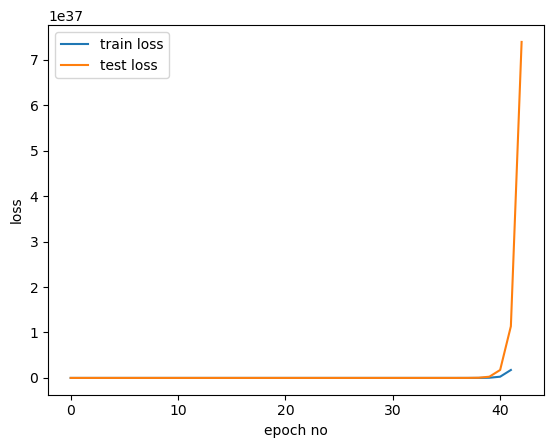

In [21]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
asd = df_data.reset_index(drop=False)
asd

,Datetime,Choke,Psig,APsig,BOPD (Oil),MMSCFD (Gas),BWPD (Air)
0,2021-05-15 21:00:00,38,935,320,698.900,4.980,23.600
1,2021-05-15 21:15:00,38,935,321,822.500,4.988,32.600
2,2021-05-15 21:30:00,38,940,318,661.400,5.070,26.200
3,2021-05-15 21:45:00,38,938,317,737.700,5.061,29.200
4,2021-05-15 22:00:00,38,940,319,661.400,5.078,26.200
...,...,...,...,...,...,...,...
101,2021-01-06 11:00:00,42,988,327,817.992,7.534,17.856
102,2021-01-06 11:15:00,42,990,328,809.208,7.545,17.664
103,2021-01-06 11:30:00,42,986,326,810.048,7.522,17.664
104,2021-01-06 11:45:00,42,985,325,827.664,7.510,18.048


In [23]:
#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)



In [24]:
test_target

array([[827.664],
       [817.992]], dtype=float32)

In [25]:
plot_len = len(test_predictions)
plot_df = asd[['Datetime', 'BOPD (Oil)']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('Datetime', inplace=True)



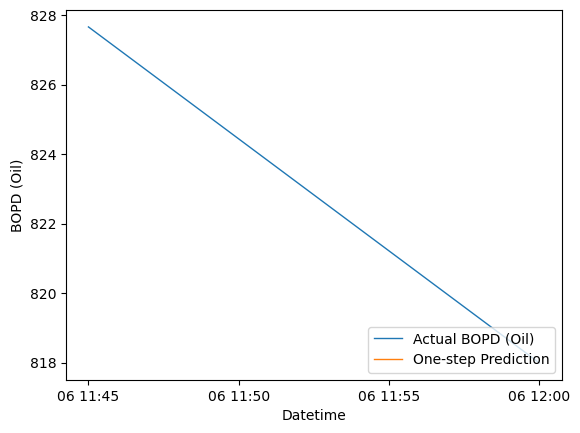

In [26]:
plt.plot(plot_df['BOPD (Oil)'], label='Actual BOPD (Oil)', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('BOPD (Oil)')
plt.legend(loc='lower right')